In [1]:
#!pip install selenium
#!pip install webdriver-manager
#!pip install bs4
#!pip install xgboost
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
import re
from sklearn.feature_extraction.text import CountVectorizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from lime.lime_tabular import LimeTabularExplainer
import requests
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time    

In [2]:
file_names_fake = pd.read_csv('C:\\Users\\Lucas Choconi\\Documents\\DH\\Datasets\\fakenews\Fake.csv')
file_names_fake['real'] = 'Fake'
file_names_true = pd.read_csv('C:\\Users\\Lucas Choconi\\Documents\\DH\\Datasets\\fakenews\True.csv')
file_names_true['real'] = 'True'
file_names = file_names_fake.append(file_names_true, ignore_index=True)
file_names.head()

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [3]:
file_names.isna().sum()

title      0
text       0
subject    0
date       0
real       0
dtype: int64

In [4]:
data_train, data_test = train_test_split(file_names, test_size=0.5, random_state=25)
sample_size = 5000
data_train = data_train.sample(sample_size)
data_test = data_test.sample(sample_size)

In [35]:
stopwords_en = stopwords.words('english')

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask_pos = np.array(Image.open(path.join(d, "Thumbs.png")))
mask_neg = np.array(Image.open(path.join(d, "Thumbsdw.png")))

wordcloud_fake = WordCloud(stopwords=stopwords_en,  mask=mask_neg, max_words=500, background_color="white").generate(data_train[data_train['real']=='Fake'].text.str.cat(sep=' '))
wordcloud_true = WordCloud(stopwords=stopwords_en, mask=mask_pos, max_words=500, background_color="white").generate(data_train[data_train['real']=='True'].text.str.cat(sep=' '))

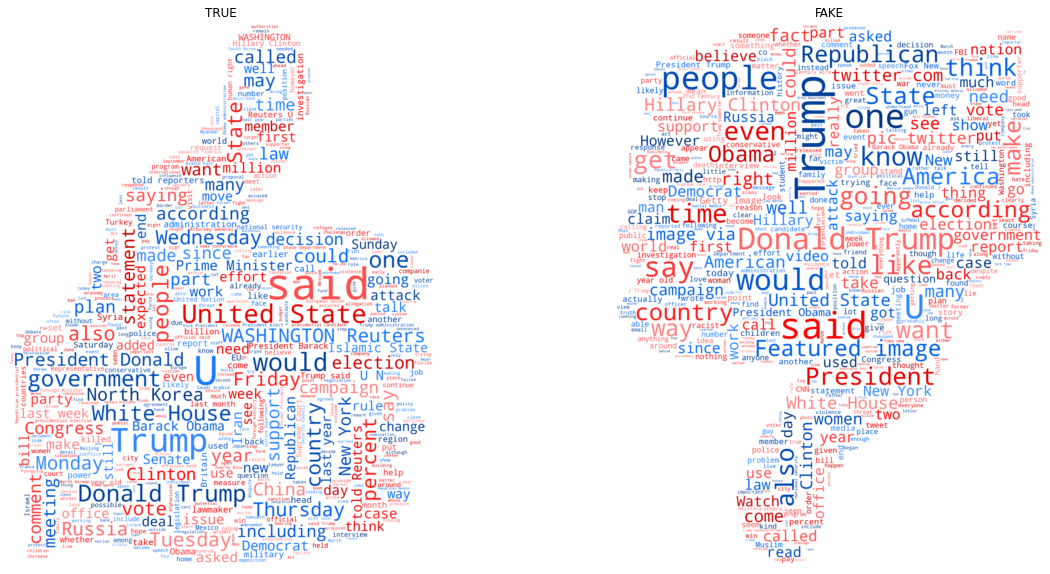

In [34]:
def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    blues = "hsl(215,100%%, %d%%)" % np.random.choice(np.arange(25, 65, 5, dtype=int))
    reds = "hsl(0,100%%, %d%%)" % np.random.choice(np.arange(40, 80, 5, dtype=int))
    choice = np.random.choice([0, 1])
    if choice == 0:
        return blues
    else:
        return reds

fig, axs = plt.subplots(1, 2,figsize=(20,10))  

axs[1].imshow(wordcloud_fake.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[1].axis("off")
axs[1].title.set_text('FAKE')
axs[0].imshow(wordcloud_true.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[0].axis("off")
axs[0].title.set_text('TRUE')
plt.show()

In [7]:
def manual_stopword_filtering(stopwords_en): 
    stopwords_en.append('reuter')
    stopwords_en.append('said')
    stopwords_en.append('Reuters')
    stopwords_en.append('via')
    stopwords_en.append('imag')
    stopwords_en.append('https')
    stopwords_en.append('com')
    stopwords_en.append('one')
    stopwords_en.append('u')
    stopwords_en.append('also')
    stopwords_en.append('would')
    stopwords_en.append('featur')
    stopwords_en.append('pic')
    stopwords_en.append('us')
    stopwords_en.append('wednesday')
    stopwords_en.append('friday')
    stopwords_en.append('monday')
    stopwords_en.append('tuesday')
    stopwords_en.append('saturday')
    stopwords_en.append('sunday')
    stopwords_en.append('thursday')
    stopwords_en.append('getti')
    stopwords_en.append('read')
    stopwords_en.append('gop')
    stopwords_en.append('watch')
    stopwords_en.append('donald')
    stopwords_en.append('trump')
    stopwords_en.append('hillari')
    stopwords_en.append('mr')
    stopwords_en.append('accord')
    stopwords_en.append('america')
    stopwords_en.append('seem')
    stopwords_en.append('youtub')
    stopwords_en.append('21st')
    stopwords_en.append('2017')
    stopwords_en.append('www')
    return stopwords_en

stopwords_en = stopwords.words('english')
stopwords_en_filtered = manual_stopword_filtering(stopwords_en)
porter = PorterStemmer()
stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
stopwords_en_filtered_poter = [porter.stem(x) for x in stopwords_en_filtered]
def porter_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso de tokenización para que se pueda 
    obtener también la raíz de la palabra.'''
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [PorterStemmer().stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_porter] # remover las stopwords
    return words

In [8]:
count_vectorizer= CountVectorizer(lowercase = True, strip_accents='unicode', \
                           tokenizer = porter_tokenizer, ngram_range = (1, 3), min_df = 3)
count_vectorizer.fit(data_train['text'])

X_train_sparse = count_vectorizer.transform(data_train['text'])
X_test_sparse = count_vectorizer.transform(data_test['text'])

C:\Users\Lucas Choconi\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [9]:
tfidft = TfidfTransformer()
tfidft.fit(X_train_sparse)

X_train = tfidft.transform(X_train_sparse)
X_test = tfidft.transform(X_test_sparse)

In [10]:
y_train = data_train.real
y_test = data_test.real

## Naive Bayes

In [11]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
NB_model.score(X_test, y_test)

0.899

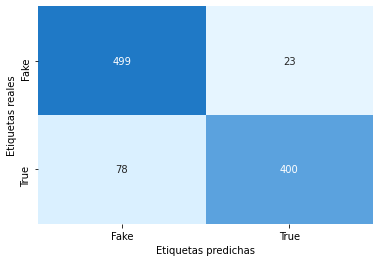

In [12]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
axis_labels = np.sort(y_test.unique())
cm_nb = confusion_matrix(y_test, NB_model.predict(X_test))
sns.heatmap(cm_nb, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

#### Modelo de Reg. Logistica

In [13]:
reg_model = LogisticRegression(C = 7, solver="saga", l1_ratio=0.5 , penalty="elasticnet", n_jobs=-1)
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

0.922

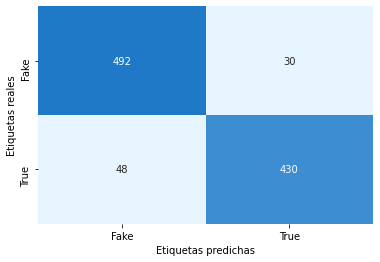

In [14]:
cm_rlog = confusion_matrix(y_test, reg_model.predict(X_test))
sns.heatmap(cm_rlog, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [15]:
X_train_dense = pd.DataFrame(X_train.todense(), 
             columns = count_vectorizer.get_feature_names()) 

Coef_reg_model = pd.DataFrame(np.transpose(reg_model.coef_), index=X_train_dense.columns, columns=['Coef'])
Coef_reg_model['coef_abs'] = abs(Coef_reg_model['Coef'])
Coef_reg_model = Coef_reg_model.reset_index(-1)
Coef_reg_model['words'] = Coef_reg_model['index'] 
Coef_reg_model['freq'] = (round(Coef_reg_model['coef_abs'] / Coef_reg_model.coef_abs.sum() * Coef_reg_model.shape[0] * 1000 , 0)).apply(lambda x: int(x))
Coef_reg_model['odds_direction'] = Coef_reg_model['Coef'].apply(lambda x: 'Negative' if x<0 else 'Positive')
Coef_reg_model_positive = Coef_reg_model[Coef_reg_model['odds_direction']=='Positive']
Coef_reg_model_positive = Coef_reg_model_positive.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)
Coef_reg_model_negative = Coef_reg_model[Coef_reg_model['odds_direction']=='Negative']
Coef_reg_model_negative = Coef_reg_model_negative.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)

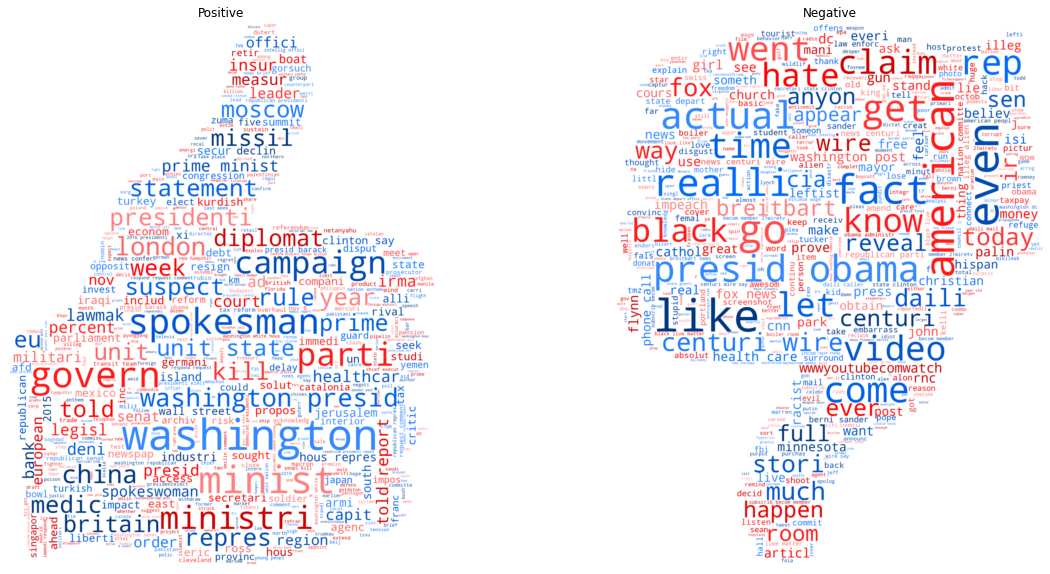

In [16]:
tuples_pos = Coef_reg_model_positive.set_index('words').T.to_dict('index')
tuples_neg = Coef_reg_model_negative.set_index('words').T.to_dict('index')

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask_pos = np.array(Image.open(path.join(d, "Thumbs.png")))
mask_neg = np.array(Image.open(path.join(d, "Thumbsdw.png")))

wordcloud_positive = WordCloud(max_words=500, mask=mask_pos, background_color="white").generate_from_frequencies(dict(tuples_pos['freq']))
wordcloud_negative = WordCloud(max_words=500, mask=mask_neg,background_color="white").generate_from_frequencies(dict(tuples_neg['freq']))

fig, axs = plt.subplots(1, 2,figsize=(20,10))
# Display the generated image:
axs[0].imshow(wordcloud_positive.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[0].axis("off")
axs[0].title.set_text('Positive')
axs[1].imshow(wordcloud_negative.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[1].axis("off")
axs[1].title.set_text('Negative')
plt.show()

## Modelo de Reg. Logistica Truncando palabras

In [17]:
svd = TruncatedSVD(n_components = 300);

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [18]:
display(svd.explained_variance_ratio_.sum())

0.5617721644304419

In [19]:
reg_model_svd = LogisticRegression(C = 8, solver="newton-cg", penalty="l2")
reg_model_svd.fit(X_train_svd, y_train)
reg_model_svd.score(X_test_svd, y_test)

0.92

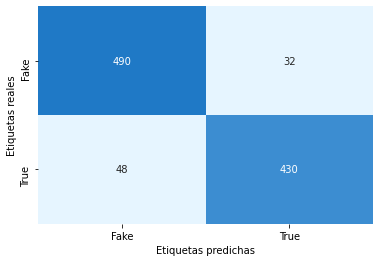

In [20]:
cm_rlog_svd = confusion_matrix(y_test, reg_model_svd.predict(X_test_svd))
sns.heatmap(cm_rlog_svd, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

## Decision Tree Classifier

In [21]:
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train, y_train)
my_tree.score(X_test, y_test)

0.791

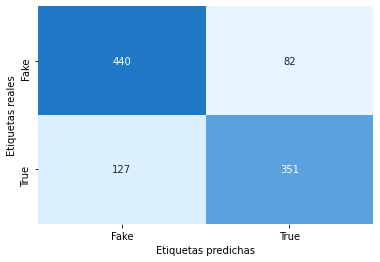

In [22]:
cm_tree = confusion_matrix(y_test, my_tree.predict(X_test))
sns.heatmap(cm_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

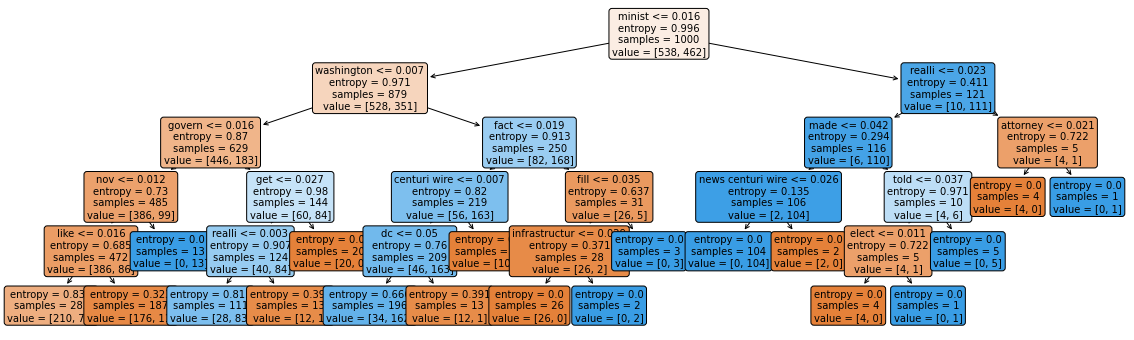

In [23]:
plt.figure(figsize=(20,6))
tree.plot_tree(my_tree,feature_names = X_train_dense.columns,filled=True,rounded=True, fontsize = 10)
plt.show()

## Boosting de Modelos

In [24]:
base_classifier = ExtraTreesClassifier(n_estimators=100, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

boost_tree = AdaBoostClassifier(base_estimator = base_classifier, 
                            n_estimators = 200,
                            learning_rate = 0.8,                                       
                            random_state = 127)

boost_tree.fit(X_train, y_train) 
boost_tree.score(X_test, y_test)

0.94

Text(0.5, 15.0, 'Etiquetas predichas')

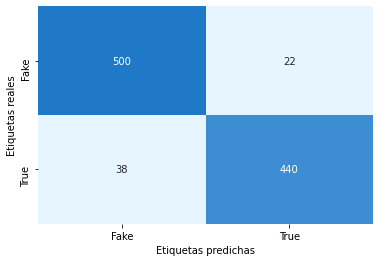

In [25]:
cm_boost_tree = confusion_matrix(y_test, boost_tree.predict(X_test))
sns.heatmap(cm_boost_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

## A traves de webscraping se buscan noticias para obtener más datos de testing

In [26]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

def get_text_from_url_bbc(url):
    wd.get(url)

    time.sleep(1)

    soup = BeautifulSoup(wd.page_source)
    text = soup.find_all('div', {'data-component': 'text-block'}) #(?P<text>\>(.*?)\<)
    text = reversed(text) 
    text2 = ""
    for i in text:
        try:
            text2 = i.text+text2
        except:
            text2 = ""+text2
    return text2    



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [C:\Users\Lucas Choconi\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [27]:

warnings.filterwarnings("ignore")
#https://newsapi.org/docs
response = requests.get("https://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey=1f83e742c8804de0a5d427510829f79b")

list_urls = []
for i in range(0,len(response.json()['articles'])):
    list_urls.append(response.json()['articles'][i]['url'])  
    
list_texts = []
for i in range(0,len(list_urls)):
    list_texts.append(get_text_from_url_bbc(list_urls[i]))

In [39]:
data_texts_text = pd.DataFrame(list_texts, columns=['text'])
data_texts_text['len'] = data_texts_text.text.apply(lambda x: len(x))
data_texts_text['real'] = 'True'
data_texts_text = data_texts_text[data_texts_text.len>0]

X_test_sparse_texts = count_vectorizer.transform(data_texts_text.text)
X_test_sparse_texts = tfidft.transform(X_test_sparse_texts)
X_test_texts = pd.DataFrame(X_test_sparse_texts.todense(), 
             columns = count_vectorizer.get_feature_names()) 
X_test_svd_texts = svd.transform(X_test_texts)

In [223]:
data_texts_text['predict_reg_base'] = reg_model.predict(X_test_texts)
data_texts_text['prob_reg_base'] = reg_model.predict_proba(X_test_texts).T[0]

data_texts_text['predict_svd'] = reg_model_svd.predict(X_test_svd_texts)
data_texts_text['prob_svd'] = reg_model_svd.predict_proba(X_test_svd_texts).T[0]

data_texts_text['predict_my_tree'] = my_tree.predict(X_test_texts)
data_texts_text['prob_my_tree'] = my_tree.predict_proba(X_test_texts).T[0]

data_texts_text['predict_boost_tree'] = boost_tree.predict(X_test_texts)
data_texts_text['prob_boost_tree'] = boost_tree.predict_proba(X_test_texts).T[0]

data_text_style = data_texts_text.style.format({"prob_reg_base": "{:.2%}", 
                          "prob_svd": "{:.2%}", 
                          "prob_my_tree": "{:.2%}",
                          "prob_boost_tree":"{:.2%}"})\
                 .format({"text": lambda x:x[:50]+"..."})\
                 .hide_index()\
                .format({"len": lambda x: "{:.0f}".format(x)})

data_text_style = data_text_style.set_properties(**{'background-color': 'white',
                           'color': 'grey',
                           'border-color': 'black'})
data_text_style.applymap(lambda x: 'color: red' if (x)=='Fake' else '')
data_text_style.set_table_styles(
   [{
       'selector': 'th',
       'props': [('background-color', '#006AFF')]
   }])

text,len,real,predict_reg_base,prob_reg_base,predict_svd,prob_svd,predict_my_tree,prob_my_tree,predict_boost_tree,prob_boost_tree
African countries are innocent victims of the war ...,2476,True,Fake,53.53%,True,43.87%,True,25.23%,True,49.40%
At least four people were killed and about 30 inju...,2754,True,True,33.25%,True,27.54%,Fake,73.68%,True,48.90%
Ukraine says the Russian army looted or damaged mo...,3565,True,True,24.12%,True,23.49%,Fake,73.68%,True,49.06%
"A week has gone by but the stadium ""fiasco"" remain...",3451,True,Fake,69.86%,Fake,73.65%,True,25.23%,Fake,50.57%
A once-in-a-lifetime drought in the western part o...,5299,True,Fake,79.03%,Fake,74.04%,Fake,94.12%,Fake,50.66%
The US company behind Tasers plans to produce stun...,2685,True,True,30.95%,True,38.53%,Fake,73.68%,True,48.75%
A viral video showing two women scaling the wall o...,1968,True,Fake,72.39%,Fake,74.97%,Fake,100.00%,Fake,50.50%
President Joe Biden has said the US should ban ass...,3728,True,Fake,71.59%,Fake,60.28%,Fake,73.68%,True,49.68%
